<h1 align="center">Automate detection and recognition of grammatical errors</h1>

<h5><b>Aim</b></h5>
To develop machine learning and deep learning algorithms in order to perform preprocessing of input text with or without grammatical errors, with an intent to first detect grammatical errors and then correct them according to the grammatical rules of the language.

## Requirements
Installing Necessary Packages

In [1]:
!nvidia-smi      #GPU for better performance

Tue May 14 02:17:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install spacy

In [3]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 11.7 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [4]:
!pip install transformers

In [5]:
!pip install wordcloud

In [6]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 6.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [7]:
!pip install torch

In [8]:
import spacy
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import transformers
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from datasets import load_dataset
import torch

# Utility functions

* Convert pargraphs into a list of sentences

---
We need to tokenize paragraphs into sentences. For this purpose, we'll use our NLP

In [9]:
def parToSent(parString):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(parString)
    return [str(i) for i in doc.sents]

* Remove unwanted spaces

---
The dataset might contain unwanted spaces. Hence we need an utility function to preprocess the data.This utility function will remove all unwanted spaces

In [10]:
# Common replacements to remove extra spaces and combine numbers
replacements = [
    (r'\s+\.', '.'),
    (r'\s+,', ','),
    (r"\s+'", "'"),
    (r'\s+\?', '?'),
    (r'\s+!', '!'),
    (r'\s+:', ':'),
    (r'\s+;', ';'),
    (r"\s+n't", "n't"),
    (r'\s+v', "n't"),
    (r'(\d+)\s+(\d+)', r'\1\2')  # Combine numbers separated by spaces
]

# Compile regex patterns for replacements
regex_patterns = [(re.compile(pattern), replacement) for pattern, replacement in replacements]

# Function to preprocess text by combining numbers and removing extra spaces
def removeExtraSpace(text):
    for pattern, replacement in regex_patterns:
        text = pattern.sub(replacement, text)
    return text

* Length of a sentence

---

We'll use this function to analyze the frequency of length of the sentences in our dataset.

In [11]:
def lenAnalysis(arr,corr):
    sns.kdeplot([len(i) for i in arr])
    plt.xlabel("Length of sentences")
    plt.ylabel("Frequency")
    if corr == 1:
        plt.title("Frequency Analysis of length of correct sentences")
    else:
        plt.title("Frequency Analysis of length of incorrect sentences")
    plt.show()
    print('\n')
    print("***Percentile Analysis***")
    for i in range(90, 101):
        print(i, " percentile= ", np.percentile([len(i) for i in arr], i))

* POS frequency
---

In [12]:
def posTagging(fileName,corr):
    your_list = []
    with open(fileName, 'r') as f:
        reader = csv.reader(f)
        if corr == 1:
            your_list = ' '.join([i[1] for i in reader])
            plt.title("Frequency Analysis of POS in correct sentences")
        else:
            your_list = ' '.join([i[0] for i in reader])
            plt.title("Frequency Analysis of POS in incorrect sentences")
    nlp = spacy.load("en_core_web_sm")
    pos_doc = nlp(your_list)
    pos_list = [str(i.pos_) for i in pos_doc]
    df = pd.DataFrame({'freq': pos_list})
    df = df.sort_values(by='freq', ascending=False)
    df.groupby('freq', as_index=True).size().plot(kind='bar')
    plt.xlabel("Parts of Speech")
    plt.ylabel("Frequency")
    plt.show()

* Word cloud

---

We'll use this function to identify the frequently recurring characters in our dataset.

In [13]:
def word_cloud(fileName, col_id, lst):
    your_list = []
    if lst == 0:
        with open(fileName, 'r') as f:
            reader = csv.reader(f)
            your_list = ' '.join([row[col_id] for row in reader])
    else:
        your_list = ' '.join(fileName)
    wordcloud = WordCloud(background_color='white', width=500, height=500).generate(your_list)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Data Collection (Dataset)
We'll be using the well-known JFLEG dataset for training our model

---
It is described as `a gold standard benchmark for developing and evaluating Grammar Error Correction systems with respect to fluency` as it has a diverse variety of correct-incorrect pairs.

In [14]:
jfleg_dataset = load_dataset("jfleg")
jfleg_dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating validation split:   0%|          | 0/755 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/748 [00:00<?, ? examples/s]

DatasetDict({
    validation: Dataset({
        features: ['sentence', 'corrections'],
        num_rows: 755
    })
    test: Dataset({
        features: ['sentence', 'corrections'],
        num_rows: 748
    })
})

We can see that there are two keys which are `Validation` and `test` which we can use for traing and validation of the model.

In [15]:
train_dataset = load_dataset("jfleg", split='validation[:]') #dataset for training our model
val_dataset = load_dataset("jfleg", split='test[:]') #dataset for validating our model

In [16]:
# Examining the dataset
train_dataset[:2]

{'sentence': ['So I think we can not live if old people could not find siences and tecnologies and they did not developped . ',
  'For not use car . '],
 'corrections': [['So I think we would not be alive if our ancestors did not develop sciences and technologies . ',
   'So I think we could not live if older people did not develop science and technologies . ',
   'So I think we can not live if old people could not find science and technologies and they did not develop . ',
   'So I think we can not live if old people can not find the science and technology that has not been developed . '],
  ['Not for use with a car . ',
   'Do not use in the car . ',
   'Car not for use . ',
   'Can not use the car . ']]}

After examining the dataset, it's apparent that for each sentence, we're provided with four corrections.

# Data preprocessing
* Generative csv functiom

---

The `generate_csv` function takes a CSV file path (`csv_path`) and a dataset as input. It iterates through the dataset, where each element contains a "sentence" and its corresponding "corrections". It writes each pair of "sentence" and "corrections" into the CSV file, after removing any extra spaces, thus creating a CSV file with two columns: "input" and "target".


In [17]:
def generate_csv(csv_path, dataset):
    with open(csv_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["input", "target"])
        for case in dataset:
            input_text = case["sentence"]
            for correction in case["corrections"]:
                if input_text and correction and (input_text != correction):
                    input_text = removeExtraSpace(input_text)
                    correction = removeExtraSpace(correction)
                    writer.writerow([input_text, correction])

In [18]:
# Generating a csv file for training
generate_csv("train.csv", train_dataset)
train_dataset.shape

(755, 2)

Generate a word cloud to identify the frequently recurring words amongst the incorrect sentences in our training set.

---

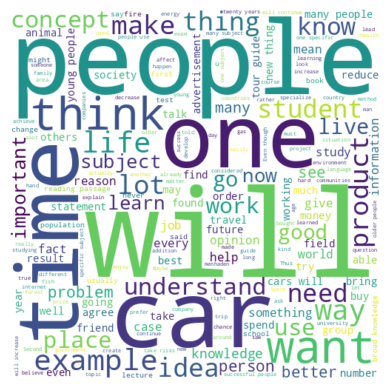

In [19]:
word_cloud("train.csv",0,0)

Generate a word cloud to identify the frequently recurring words amongst the correct sentences in our training set.

---

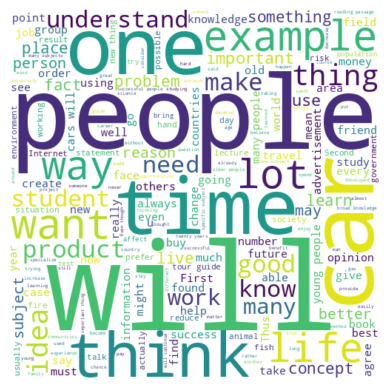

In [20]:
word_cloud("train.csv",1,0)

Word cloud analysis on words which are present in `incorrect` sentences but not present in `correct` sentences in training set.

---

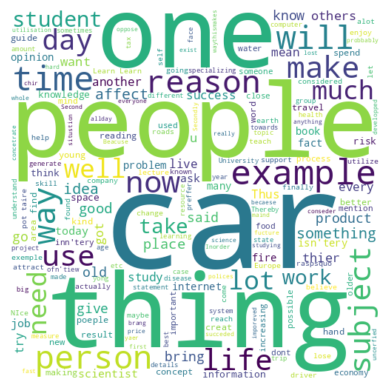

In [21]:

tr_inc = []
for i in range(755):
  inc_snt = removeExtraSpace(train_dataset['sentence'][i])
  for crcSent in train_dataset['corrections'][i]:
    crc_snt = removeExtraSpace(crcSent)
    for i in list(inc_snt.split()):
      if i not in list(crc_snt.split()):
        tr_inc.append(str(i))
word_cloud(tr_inc,999,1)


Word cloud analysis on words which are present in `correct` sentences but not present in `incorrect` sentences in training set.

---

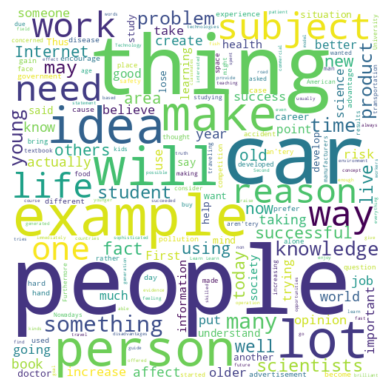

In [22]:
tr_crc = []
for i in range(755):
  inc_snt = removeExtraSpace(train_dataset['sentence'][i])
  for crcSent in train_dataset['corrections'][i]:
    crc_snt = removeExtraSpace(crcSent)
    for i in list(crc_snt.split()):
      if i not in list(inc_snt.split()):
        tr_crc.append(str(i))
word_cloud(tr_crc,999,1)

Frequency analysis of length of incorrect sentences in the training dataset

---

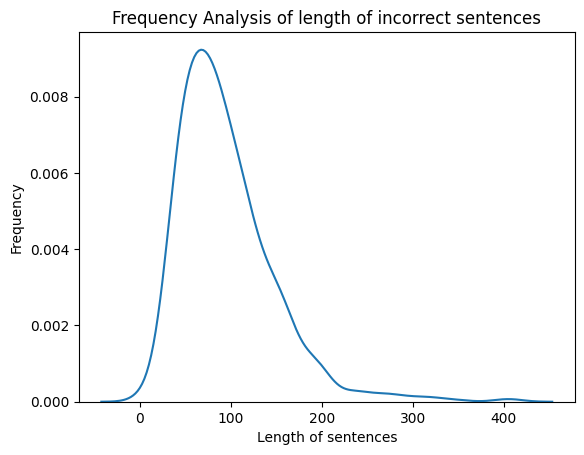



***Percentile Analysis***
90  percentile=  159.0
91  percentile=  164.0
92  percentile=  167.0
93  percentile=  174.22000000000003
94  percentile=  182.51999999999998
95  percentile=  192.0
96  percentile=  196.0
97  percentile=  205.38
98  percentile=  240.83999999999992
99  percentile=  286.9800000000005
100  percentile=  411.0


In [23]:
lenAnalysis(train_dataset["sentence"],0)

Frequency analysis of length of correct sentences in the training dataset

---

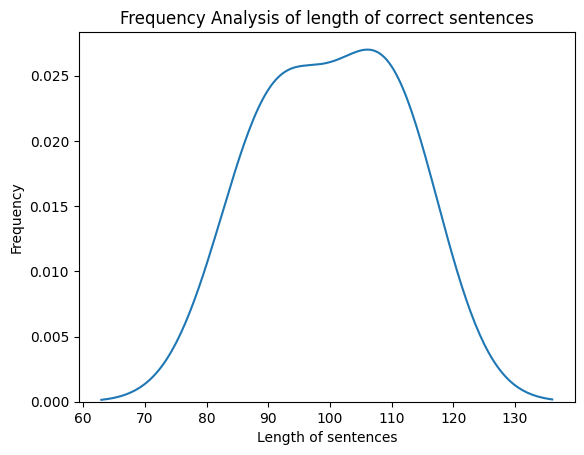



***Percentile Analysis***
90  percentile=  110.1
91  percentile=  110.19
92  percentile=  110.28
93  percentile=  110.37
94  percentile=  110.46
95  percentile=  110.55
96  percentile=  110.64
97  percentile=  110.73
98  percentile=  110.82
99  percentile=  110.91
100  percentile=  111.0


In [24]:
lenAnalysis(train_dataset["corrections"][0],1)

POS tagging

---

Frequency analysis of Parts Of Speech in incorrect sentences in training set

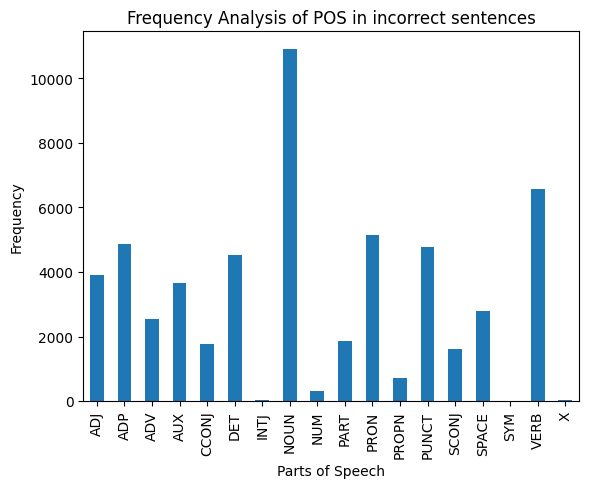

In [25]:
posTagging("train.csv",0)

Frequency analysis of Parts Of Speech in correct sentences in training set

---

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


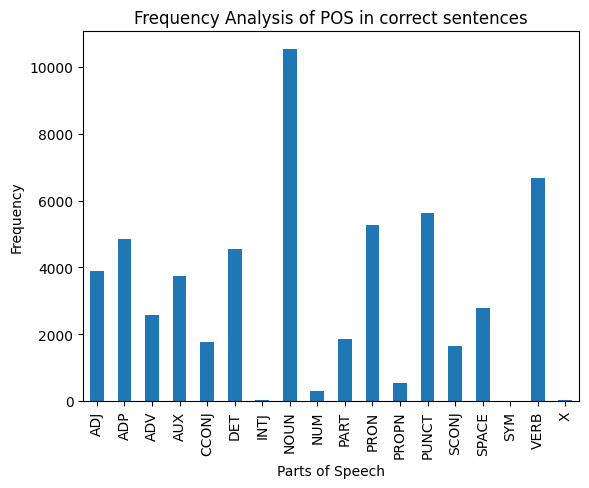

In [26]:
posTagging("train.csv",1)

In [27]:
# Generating a csv file for training
generate_csv("val.csv", val_dataset)
val_dataset.shape

(748, 2)

Generate a word cloud to identify the frequently recurring words amongst the incorrect sentences in our validation set.

---

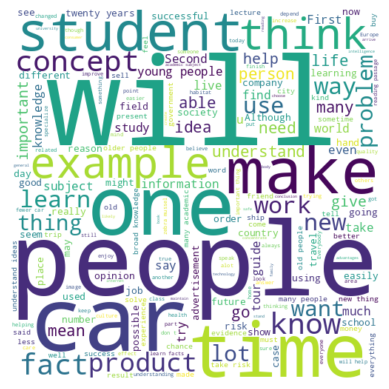

In [28]:
word_cloud("val.csv",0,0)

Generate a word cloud to identify the frequently recurring words amongst the correct sentences in our validation set.

---

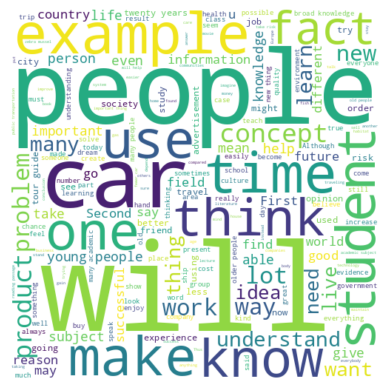

In [29]:
word_cloud("val.csv",1,0)

Word cloud analysis on words which are present in `incorrect` sentences but not present in `correct` sentences in validation set.

---

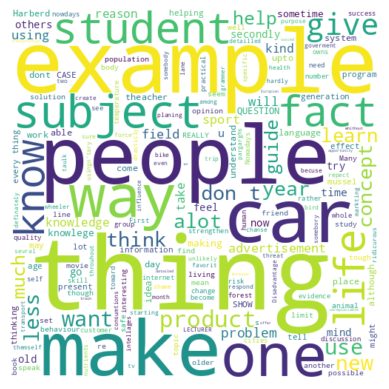

In [30]:
val_inc = []
for i in range(748):
  inc_snt = removeExtraSpace(val_dataset['sentence'][i])
  for crcSent in val_dataset['corrections'][i]:
    crc_snt = removeExtraSpace(crcSent)
    for i in list(inc_snt.split()):
      if i not in list(crc_snt.split()):
        val_inc.append(str(i))
word_cloud(val_inc,999,1)

Word cloud analysis on words which are present in `correct` sentences but not present in `incorrect` sentences.

---

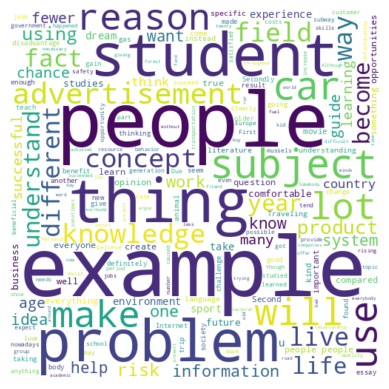

In [31]:
val_crc = []
for i in range(748):
  inc_snt = removeExtraSpace(val_dataset['sentence'][i])
  for crcSent in val_dataset['corrections'][i]:
    crc_snt = removeExtraSpace(crcSent)
    for i in list(crc_snt.split()):
      if i not in list(inc_snt.split()):
        val_crc.append(str(i))
word_cloud(val_crc,999,1)

Frequency analysis of length of incorrect sentences in the validation dataset

---

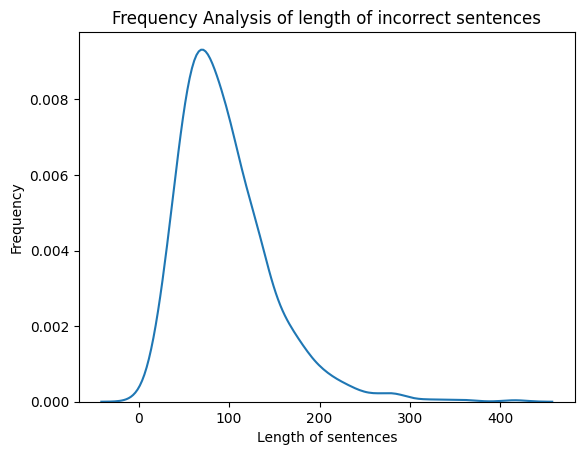



***Percentile Analysis***
90  percentile=  161.0
91  percentile=  165.0
92  percentile=  169.48000000000002
93  percentile=  178.1300000000001
94  percentile=  184.0
95  percentile=  189.5999999999999
96  percentile=  202.12
97  percentile=  214.5400000000002
98  percentile=  231.23999999999978
99  percentile=  276.2399999999998
100  percentile=  416.0


In [32]:
lenAnalysis(val_dataset["sentence"],0)

Frequency analysis of length of correct sentences in the validation dataset

---

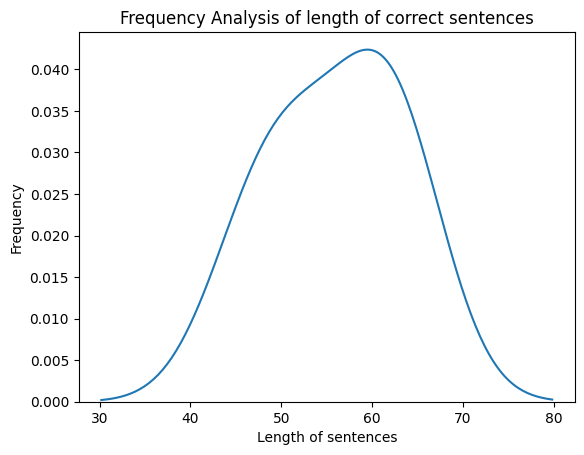



***Percentile Analysis***
90  percentile=  62.4
91  percentile=  62.46
92  percentile=  62.52
93  percentile=  62.58
94  percentile=  62.64
95  percentile=  62.7
96  percentile=  62.76
97  percentile=  62.82
98  percentile=  62.88
99  percentile=  62.94
100  percentile=  63.0


In [33]:
lenAnalysis(val_dataset["corrections"][0],1)

POS tagging

---

Frequency analysis of Parts Of Speech in incorrect sentences in validation set

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


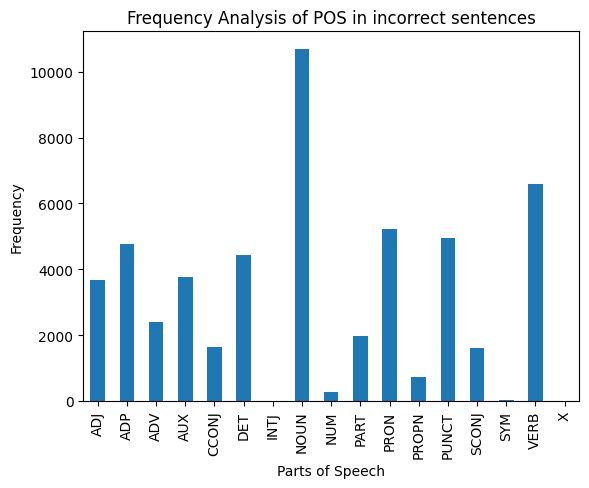

In [34]:
posTagging("val.csv",0)

Frequency analysis of Parts Of Speech in correct sentences in validation set

---

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


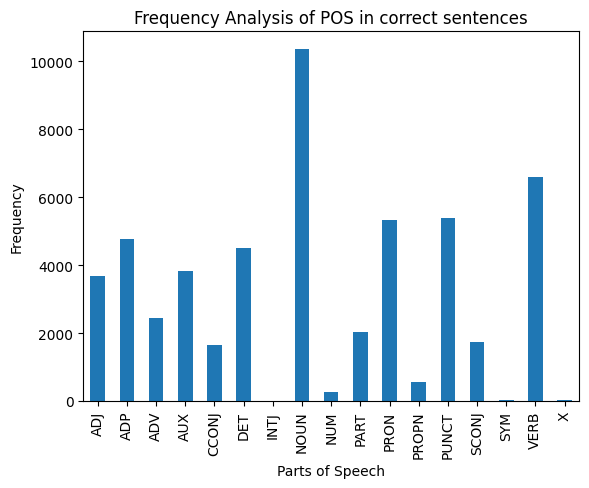

In [35]:
posTagging("val.csv",1)

In [36]:
!pip install transformers[torch]

In [37]:
!pip install accelerate -U

# Model Training
* We are using t5-base model for this
---

In [38]:
import torch
from transformers import Trainer, TrainingArguments, utils
utils.logging.set_verbosity_error()

In [39]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from datasets import load_dataset
import torch

# Load your dataset
dataset = load_dataset("csv", data_files={"train": "train.csv"}, split="train")

# Define the T5 tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("t5-base")
model = T5ForConditionalGeneration.from_pretrained("t5-base")

# Define training arguments
training_args = TrainingArguments(
    output_dir="./t5-fine-tuned",
    overwrite_output_dir=True,
    num_train_epochs=10,
    per_device_train_batch_size=4,
    save_steps=1000,
    save_total_limit=2,
    prediction_loss_only=True,
)

# Define a function to preprocess the data and tokenize it
def preprocess_function(examples):
    inputs = examples["input"]
    targets = examples["target"]
    tokenized_inputs = tokenizer(inputs, return_tensors="pt", padding="max_length", truncation=True, max_length=512)
    tokenized_targets = tokenizer(targets, return_tensors="pt", padding="max_length", truncation=True, max_length=512)
    return {"input_ids": tokenized_inputs["input_ids"], "attention_mask": tokenized_inputs["attention_mask"],
            "labels": tokenized_targets["input_ids"]}


# Apply the preprocessing function to the dataset
train_dataset = dataset.map(preprocess_function, batched=True)

# Define a function to compute the token classification loss
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions.argmax(-1)
    return {"accuracy": (pred_ids == labels_ids).mean().item()}

# Define the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    compute_metrics=compute_metrics,
)

# Fine-tune the model
trainer.train()

# Save the fine-tuned model
model.save_pretrained("./t5-fine-tuned-final")
tokenizer.save_pretrained("./t5-fine-tuned-final")


Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/2800 [00:00<?, ? examples/s]

{'loss': 0.569, 'grad_norm': 0.2349696159362793, 'learning_rate': 4.642857142857143e-05, 'epoch': 0.7142857142857143}
{'loss': 0.0271, 'grad_norm': 0.0764770433306694, 'learning_rate': 4.2857142857142856e-05, 'epoch': 1.4285714285714286}
{'loss': 0.0238, 'grad_norm': 0.09237430989742279, 'learning_rate': 3.928571428571429e-05, 'epoch': 2.142857142857143}
{'loss': 0.0209, 'grad_norm': 0.10186673700809479, 'learning_rate': 3.571428571428572e-05, 'epoch': 2.857142857142857}
{'loss': 0.0191, 'grad_norm': 0.09857645630836487, 'learning_rate': 3.2142857142857144e-05, 'epoch': 3.571428571428571}
{'loss': 0.0175, 'grad_norm': 0.06954756379127502, 'learning_rate': 2.857142857142857e-05, 'epoch': 4.285714285714286}
{'loss': 0.0168, 'grad_norm': 0.10091003775596619, 'learning_rate': 2.5e-05, 'epoch': 5.0}
{'loss': 0.015, 'grad_norm': 0.0737033411860466, 'learning_rate': 2.1428571428571428e-05, 'epoch': 5.714285714285714}
{'loss': 0.0147, 'grad_norm': 0.11100669950246811, 'learning_rate': 1.785714

('./t5-fine-tuned-final/tokenizer_config.json',
 './t5-fine-tuned-final/special_tokens_map.json',
 './t5-fine-tuned-final/spiece.model',
 './t5-fine-tuned-final/added_tokens.json')

In [42]:
import pickle
# Save the model to a pickle file
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

1. **Training Loss and Gradient Norm:**
   - The training started with a loss of 0.569 and a gradient norm of 0.2349.
   - Over epochs, the loss decreased significantly to 0.0123, indicating that the model improved its performance during training.
   - The gradient norm also decreased, suggesting stable training and convergence.

2. **Learning Rate Schedule:**
   - The learning rate decreased gradually over epochs, starting from 4.6429e-05 and reaching 0 at the end of training.
   - This learning rate schedule is common in many training setups, where the learning rate decreases to help the model converge better towards the end of training.

3. **Training Duration and Performance:**
   - The training runtime was approximately 7792.75 seconds (about 2 hours and 9 minutes), with a training speed of 3.593 samples per second.
   - The model achieved a final training loss of 0.0564, which indicates the average loss over the entire training process.

4. **Epoch Information:**
   - Each epoch lasted for about 10.0 units, indicating that the model was trained for 10 epochs in total.
   - The model's performance improved steadily across epochs, as seen from the decreasing loss and gradient norm.

Overall, the training process seems to have been successful, with the model achieving a low loss and stable gradient norms by the end of training. The learning rate schedule and training duration also suggest a well-managed training setup.

# Ease-of-use and demo
* Creating a class for our ease of use
---

In [43]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

class SentenceCorrector:
    def __init__(self, model_path):
        # Load the fine-tuned T5 model and tokenizer
        self.model = T5ForConditionalGeneration.from_pretrained(model_path)
        self.tokenizer = T5Tokenizer.from_pretrained(model_path)

    def correct_sentence(self, sentence):
        # Tokenize the input sentence
        inputs = self.tokenizer(sentence, return_tensors="pt")

        # Generate the corrected sentence
        output = self.model.generate(**inputs)

        # Decode the output tokens
        corrected_sentence = self.tokenizer.decode(output[0], skip_special_tokens=True)

        return corrected_sentence

    def correct_and_highlight(self, input_text):
        if '\n' in input_text:  # Check if input_text is a paragraph
            sentences = input_text.split('\n')
            corrected_sentences = []
            for sentence in sentences:
                corrected_sentence = self.correct_sentence(sentence)
                corrected_sentences.append(corrected_sentence)
        else:  # Input is a single sentence
            corrected_sentences = [self.correct_sentence(input_text)]

        # Convert corrected_sentences to list of strings
        corrected_sentences = [s if isinstance(s, str) else ' '.join(s) for s in corrected_sentences]

        # Highlight words not present in the output sentence
        highlighted_input = []
        highlighted_output = []
        output_sentence = corrected_sentences[0] if corrected_sentences else ""
        for original, corrected in zip(input_text.split(), output_sentence.split()):
            if original != corrected:
                highlighted_input.append("\033[91m" + original + "\033[0m")  # Red color for input
                highlighted_output.append("\033[92m" + corrected + "\033[0m")  # Green color for output
            else:
                highlighted_input.append(original)
                highlighted_output.append(corrected)

        return ' '.join(highlighted_input), ' '.join(highlighted_output)

# Example usage
model_path = "./t5-fine-tuned-final"

In [45]:
sentence_corrector = SentenceCorrector(model_path)
input_text = "He do not like the car."
highlighted_input, highlighted_output = sentence_corrector.correct_and_highlight(input_text)
print("Input Sentence:", highlighted_input)
print("Corrected Sentence:", highlighted_output)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Input Sentence: He do not like the car.
Corrected Sentence: He does not like the car.


# Validation
* Using val.csv for validation
---

In [57]:
# Load your validation dataset
val_dataset = load_dataset("csv", data_files={"val": "val.csv"}, split="val")

# Apply the same preprocessing function to the validation dataset
val_dataset = val_dataset.map(preprocess_function, batched=True)

# Evaluate the model on the validation dataset
eval_results = trainer.evaluate(eval_dataset=val_dataset)

# Print the evaluation results, including accuracy
print(eval_results)


Generating val split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/2731 [00:00<?, ? examples/s]

{'eval_loss': 0.024349411949515343, 'eval_runtime': 252.9693, 'eval_samples_per_second': 10.796, 'eval_steps_per_second': 1.352, 'epoch': 10.0}
{'eval_loss': 0.024349411949515343, 'eval_runtime': 252.9693, 'eval_samples_per_second': 10.796, 'eval_steps_per_second': 1.352, 'epoch': 10.0}


In [47]:
sc= SentenceCorrector("./t5-fine-tuned-final")

In [49]:
sc.correct_sentence('My camera battery a dead')

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


'My camera battery is dead.'

In [75]:
sentences = [
    'They want their website to load quicker.',
    'They wants their website load quicker.',
    'I wish my Computer was run faster.'
]

In [76]:
for sentence in sentences:
    res = sc.correct_and_highlight(sentence)
    highlighted_input, highlighted_output = res
    print("Original Sentence:", highlighted_input)
    print("Corrected Sentence:", highlighted_output)

Original Sentence: They want their website to load quicker.
Corrected Sentence: They want their website to load faster.
Original Sentence: They wants their website load quicker.
Corrected Sentence: They want their website to load
Original Sentence: I wish my Computer was run faster.
Corrected Sentence: I wish my Computer was running faster.


# Graphical User Interface
---
Let us create a simple Graphical User Interface (GUI) using gradio

In [58]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.8/315.8 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 12.5 MB

In [59]:
import gradio as gr

In [68]:
def correct(sentence):
    # If the input is a paragraph, convert it to sentences first
    sentences = parToSent(sentence)


    # Remove extra spaces from each sentence
    cleaned_sentences = [removeExtraSpace(sent) for sent in sentences]

    # Correct each sentence using SentenceCorrector's correct_sentence method
    corrected_sentences = [sc.correct_sentence(sent) for sent in cleaned_sentences]

    # Combine the corrected sentences into a single string
    corrected_text = ' '.join(corrected_sentences)

    return corrected_text

In [69]:
demo = gr.Interface(fn=correct, inputs="text", outputs="text", title ="Enter a Sentence for grammer correction")
demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://cc7606edbaf5a6eea4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
